### Установка зависимостей

Для увеличения скорости работы, будем загружать картинки из RAM. Памяти может не хватить, поэтому крашнем Colab, чтобы получить 25GB RAM:

In [0]:
d=[]
while(1):
  d.append('1')

In [0]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)


In [0]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

5.3.0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Распаковка картинок:

In [0]:
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/NN/Simpsons/simpsons4.zip -d simpsons4

In [0]:
!ls /content/simpsons4/train/simpsons_dataset

abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


Добавим картинки в классы с очень малой выборкой (disco_stu, lionel_hutz, miss_hoover, troy_mcclure), чтобы иметь не менее 20 картинок каждого класса:

In [0]:
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/NN/Simpsons/add -d add
!cp -a /content/add/. /content/simpsons4/train/simpsons_dataset/

In [0]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Dec 31 19:04:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

В качестве аугментации тренинговой выборки будем делать увеличение размера картинки до 255х255, случайный кроп размера 224х224, случайное отображение по горизонтали и иногда для некоторых моделей в ансамбле добавление шума:

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
              pickle.dump(self.label_encoder, le_dump_file)

        # параллельная загрузка изображений в память
        self.samples = []
        with tqdm(desc=f"Loading {self.mode} files", total=self.len_) as pbar:
          p = ThreadPool()
          for sample in p.imap(self.load_sample, self.files):
            self.samples.append(sample)
            pbar.update()

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        AUG_transform = transforms.Compose([
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        x = self.samples[index] # для чтения из памяти вместо x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = x.resize((255, 255))
            x = AUG_transform(x)
            #x += 0.05*torch.randn_like(x)
        else:
            x = x.resize((RESCALE_SIZE, RESCALE_SIZE))
            x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [0]:
TRAIN_DIR = Path('/content/simpsons4/train/simpsons_dataset')
TEST_DIR = Path('/content/simpsons4/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [0]:
# Очистить память в случае повторной инициализации dataset
train_dataset = None
val_dataset = None

In [0]:
# Можно и так, если предыдущая ячейка не освободила память
del train_dataset
del val_dataset

Загрузим все картинки в RAM:

In [0]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val') 

Loading val files: 100%|██████████| 4187/4187 [00:08<00:00, 509.26it/s]


Давайте посмотрим на наших героев внутри датасета.

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

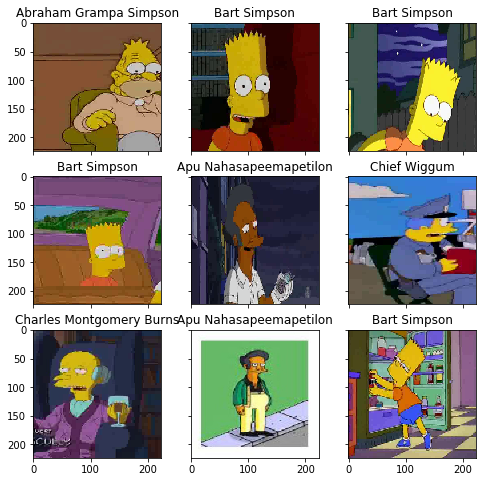

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Обучение на одной эпохе:

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # перевод модели в режим train необходимо, если в модели есть слои BatchNorm или DropOut
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm_notebook(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
           
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Будем отслеживать val_acc и сохранять веса модели только в случае улучшения результата классификации:

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm_notebook(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    global best_val_acc
    if val_acc > best_val_acc:
        torch.save(simple_cnn.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model_weights.pth")
        best_val_acc = val_acc

    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size, lr=1e-3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in tqdm_notebook(test_loader):
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

*Описание сверточных слоев*:

1. размерность входа: 3x224x224 
2. размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 128x5x5

*Описание линейных слоев*:
7. Линейный слой (3200), батчнорм, ReLU, дропаут (p=0.5)
8. Линейный слой (3200), батчнорм, ReLU, дропаут (p=0.5)
9. Линейный слой (42)

In [0]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
 
        self.out = nn.Sequential(
            nn.Linear(128 * 5 * 5, 128 * 5 * 5),
            nn.BatchNorm1d(128 * 5 * 5),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128 * 5 * 5, 128 * 5 * 5),
            nn.BatchNorm1d(128 * 5 * 5),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128 * 5 * 5, n_classes)
        )
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [0]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [0]:
import torchsummary
torchsummary.summary(simple_cnn.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13          [-1, 128, 10, 10]          73,856
             ReLU-14          [-1, 128,

Запустим обучение сети. После некоторого количества эпох будем каждый раз уменьшать шаг learning_rate. Отсутвие scheduler тут намеренное, так как для более тонкой настройки было удобнее вручную конролировать обучение модели, отслеживая loss и acc.

Строго говоря, запускать каждый раз обучение повторно для изменения шага learning_rate не совсем правильно, так как приходятся заново инициализировать оптимизатор. Но практика показала, что даннное допущение не влияет на конечный результат. 

In [0]:
best_val_acc = 0
history =  train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64, lr=1e-3)
history += train(train_dataset, val_dataset, model=simple_cnn, epochs=3, batch_size=64, lr=0.5e-3)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

epoch:  10%|█         | 1/10 [00:37<05:39, 37.69s/it]


Epoch 001 train_loss: 2.2507 val_loss 1.5210 train_acc 0.4117 val_acc 0.5940


epoch:  20%|██        | 2/10 [01:15<05:01, 37.70s/it]

epoch:  20%|██        | 2/10 [01:15<05:01, 37.70s/it]


Epoch 002 train_loss: 1.3299 val_loss 1.1018 train_acc 0.6401 val_acc 0.7081


epoch:  30%|███       | 3/10 [01:53<04:23, 37.70s/it]


Epoch 003 train_loss: 0.9819 val_loss 0.9999 train_acc 0.7272 val_acc 0.7325


epoch:  40%|████      | 4/10 [02:30<03:46, 37.74s/it]



Epoch 004 train_loss: 0.7639 val_loss 0.8453 train_acc 0.7856 val_acc 0.7858


epoch:  50%|█████     | 5/10 [03:08<03:08, 37.73s/it]



Epoch 005 train_loss: 0.6367 val_loss 0.6592 train_acc 0.8200 val_acc 0.8192


epoch:  60%|██████    | 6/10 [03:46<02:30, 37.70s/it]



Epoch 006 train_loss: 0.5448 val_loss 0.6501 train_acc 0.8447 val_acc 0.8252


epoch:  70%|███████   | 7/10 [04:24<01:53, 37.72s/it]


Epoch 007 train_loss: 0.4884 val_loss 0.6244 train_acc 0.8584 val_acc 0.8397


epoch:  80%|████████  | 8/10 [05:01<01:15, 37.74s/it]



Epoch 008 train_loss: 0.4263 val_loss 0.5618 train_acc 0.8765 val_acc 0.8634


epoch:  90%|█████████ | 9/10 [05:39<00:37, 37.72s/it]


Epoch 009 train_loss: 0.3848 val_loss 0.5479 train_acc 0.8861 val_acc 0.8696


epoch:   0%|          | 0/3 [00:00<?, ?it/s]



Epoch 010 train_loss: 0.3486 val_loss 0.5534 train_acc 0.8978 val_acc 0.8629


epoch:  33%|███▎      | 1/3 [00:37<01:15, 37.67s/it]


Epoch 001 train_loss: 0.2512 val_loss 0.5098 train_acc 0.9260 val_acc 0.8856


epoch:  67%|██████▋   | 2/3 [01:15<00:37, 37.65s/it]



Epoch 002 train_loss: 0.2039 val_loss 0.4845 train_acc 0.9384 val_acc 0.8923


epoch: 100%|██████████| 3/3 [01:53<00:00, 37.67s/it]



Epoch 003 train_loss: 0.1751 val_loss 0.4713 train_acc 0.9470 val_acc 0.9009


In [0]:
history += train(train_dataset, val_dataset, model=simple_cnn, epochs=3, batch_size=64, lr=0.1e-3) 
history += train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64, lr=0.05e-3) 
history += train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64, lr=0.02e-3) 
history += train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64, lr=0.005e-3)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch:  33%|███▎      | 1/3 [00:37<01:15, 37.56s/it]



Epoch 001 train_loss: 0.1198 val_loss 0.4128 train_acc 0.9629 val_acc 0.9114


epoch:  67%|██████▋   | 2/3 [01:15<00:37, 37.63s/it]



Epoch 002 train_loss: 0.0949 val_loss 0.4094 train_acc 0.9710 val_acc 0.9140


epoch:   0%|          | 0/2 [00:00<?, ?it/s]



Epoch 003 train_loss: 0.0867 val_loss 0.4034 train_acc 0.9744 val_acc 0.9121


epoch:  50%|█████     | 1/2 [00:37<00:37, 37.70s/it]


Epoch 001 train_loss: 0.0790 val_loss 0.3968 train_acc 0.9765 val_acc 0.9190


epoch:   0%|          | 0/2 [00:00<?, ?it/s]



Epoch 002 train_loss: 0.0735 val_loss 0.4026 train_acc 0.9787 val_acc 0.9162


epoch:  50%|█████     | 1/2 [00:37<00:37, 37.46s/it]



Epoch 001 train_loss: 0.0684 val_loss 0.4001 train_acc 0.9799 val_acc 0.9176


epoch:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.0679 val_loss 0.3913 train_acc 0.9799 val_acc 0.9202


epoch:  50%|█████     | 1/2 [00:37<00:37, 37.30s/it]



Epoch 001 train_loss: 0.0651 val_loss 0.4003 train_acc 0.9804 val_acc 0.9181


epoch: 100%|██████████| 2/2 [01:14<00:00, 37.30s/it]



Epoch 002 train_loss: 0.0598 val_loss 0.3978 train_acc 0.9831 val_acc 0.9186


Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

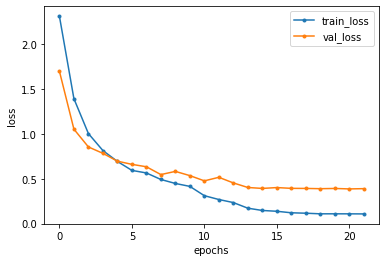

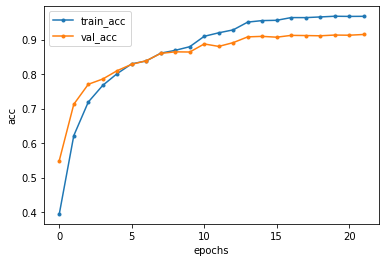

In [0]:
#plt.figure(figsize=(8, 5))
plt.plot(loss, label="train_loss", marker='.')
plt.plot(val_loss, label="val_loss", marker='.')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.plot(acc, label="train_acc", marker='.')
plt.plot(val_acc, label="val_acc", marker='.')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ансамблирование и оценка результатов




Проведем обучение несколько раз, сохраним веса полученных моделей, создадим их ансамбль:

In [0]:
# Ансамблирование
weight_files = []
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model10_weights09147.pth")
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model13_weights09205.pth")
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model14_weights09224.pth")
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model15_weights09207.pth")
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model16_weights09150.pth")
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model17_weights09229.pth")
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model18_weights09186.pth")
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model19_weights09176.pth")
weight_files.append("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/best_model20_weights09202.pth")

ensemble = []
for i in range(len(weight_files)):
  simple_cnn = SimpleCnn(n_classes).to(DEVICE)
  simple_cnn.load_state_dict(torch.load(weight_files[i]))
  ensemble.append(simple_cnn)
  ensemble[i].eval()

Классифицируем 1000 случайных картинок из val_dataset с помощью ансамбля 9 моделей:

In [0]:
idxs = list(map(int, np.random.uniform(0, 0.2 * len(train_val_files) - 1, 1000)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(ensemble[0], imgs)
for i in range(1, len(ensemble)):
  probs_ims += predict(ensemble[i], imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

Посмотрим на f1-score. Конечно, отображаемый ниже результат весьма условен, так как для каждой модели заново делался train_test_split. Это привело к тому, что в ансамбле моделей потерялось разделение на train и val, но зато увеличилась предсказательная сила, обученная на всем датасете.

In [0]:
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average='macro')

0.9920227580334977

### Submit на Kaggle

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
#probs = predict(simple_cnn, test_loader)

# ансамбль
probs = predict(ensemble[0], test_loader)
for i in range(1, len(ensemble)):
  probs += predict(ensemble[i], test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [0]:
import pandas as pd
# my_submit = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
my_submit.to_csv('/content/gdrive/My Drive/Colab Notebooks/NN/Simpsons/simple_cnn_baseline.csv', index=False)